In [14]:
%run -i 'src/SPV.py'
from src.data_functions import *
from src.solution_algorithms import *

In [15]:
df = pd.read_csv('data/full_randomized_2017_hourly_normalized_v2.csv')
df.head()

,dataid,localhour,use,gen_per_kW
0,26,2017-01-01 00:00:00,1.788817,0.0
1,26,2017-01-01 01:00:00,1.223917,0.0
2,26,2017-01-01 02:00:00,0.668367,0.0
3,26,2017-01-01 03:00:00,0.478667,0.0
4,26,2017-01-01 04:00:00,0.416283,0.0


In [16]:
dataids = obtain_dataid_2017(df)
dataids_array = np.asarray(dataids)
validdata = len(dataids)
T = len(df[df.dataid==26].use.values)
localtime_data = df[df.dataid==26].localhour

In [17]:
gen_kw = f_gen_per_kw(df)
load_kw = f_load_kw(df)

1 m$^2$ is 1550 in$^2$

Typical size of solar panel: is 65 in for 39 in = 2535 in$^2$ = 1.6354 m$^2$.

The rated power of a solar panel is typically between 250 to 350W.

To convert we use: gen_per_kw by 0.3 / 1.6354 to get gen_per_m$^2$.

In [18]:
gen_per_m2 = gen_kw*0.3/1.6354

In [19]:
#Investment per m2 is 512.2 $/m2.
#Using an anualized cost with discount rate r=5%, we obtain
CostPVperM2 = 512.2
r = 0.05
years = 20
annuity = CostPVperM2*r/(1-(1+r)**(-years)) #Obtain Annuity 
pi_s = annuity/T #Obtain cost per time step
print('Cost of PV per time step: ' + str(pi_s))

Cost of PV per time step: 0.004695025492240356


In [20]:
firms = validdata #Number of firms
gamma = 1 #Factor of NM price
pi_r = 0.18   #Retail Price at 18 cents per kWh.
pi_nm = gamma*pi_r  #Net Metering Price
a_cap_firms = f_cap_firms(gen_per_m2, load_kw) #Cap for firms to not be net producers
a_max_firms = 0.2*a_cap_firms

In [14]:
pv_changes = []
#gamma = np.linspace(0,1,21)
gamma = [0.9]
for g in gamma:
    pi_nm = g*pi_r
    %run -i 'src/Case_01.py'
    pv_changes.append(aux)
    clear_output()

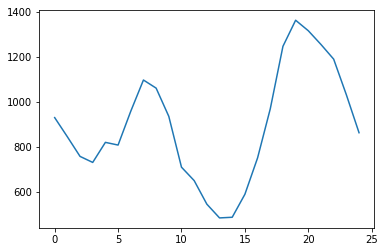

In [33]:
coll_load = f_collective_load(load_kw)
coll_gen = f_collective_gen(gen_per_m2, sol_sharing)
coll_net_load = coll_load - coll_gen
plt.plot(coll_net_load[24*31:24*32+1])

In [40]:
print(coll_net_load[24*31:24*32])

[ 929.51619342  844.16001389  756.69664153  729.78653056  819.19643405
  807.18477984  957.81448511 1096.96188602 1060.86053488  934.9456911
  708.62440244  648.80449487  543.85831704  482.56059393  485.4801447
  587.8861991   749.93696978  968.37959581 1247.05265074 1363.29852708
 1316.53304956 1255.24964595 1189.96122378 1031.30036925]


In [31]:
localtime_data[24*31:24*32+1]

744    2017-02-01 00:00:00
745    2017-02-01 01:00:00
746    2017-02-01 02:00:00
747    2017-02-01 03:00:00
748    2017-02-01 04:00:00
749    2017-02-01 05:00:00
750    2017-02-01 06:00:00
751    2017-02-01 07:00:00
752    2017-02-01 08:00:00
753    2017-02-01 09:00:00
754    2017-02-01 10:00:00
755    2017-02-01 11:00:00
756    2017-02-01 12:00:00
757    2017-02-01 13:00:00
758    2017-02-01 14:00:00
759    2017-02-01 15:00:00
760    2017-02-01 16:00:00
761    2017-02-01 17:00:00
762    2017-02-01 18:00:00
763    2017-02-01 19:00:00
764    2017-02-01 20:00:00
765    2017-02-01 21:00:00
766    2017-02-01 22:00:00
767    2017-02-01 23:00:00
768    2017-02-02 00:00:00
Name: localhour, dtype: object

In [39]:
load_dataid_330 = load_kw[:,6]
gen_dataid_330 = gen_per_m2[:,6]*investment_standalone[6]
netload_dataid_330 = load_dataid_330 - gen_dataid_330
print(netload_dataid_330[24*31:24*32])

[ 0.72421667  0.64238333  0.56946667  0.60318333  0.63863333  0.54948333
  0.5576      0.6841555   0.47473337  0.11177768 -0.58855994 -1.04433064
 -1.34983957 -0.26789962  2.64641096  2.94450022  2.02627008  0.25964339
  0.90963333  0.85818333  0.78878333  0.6367      0.63215     0.50681667]


In [12]:
print(pv_changes)

[1.0593219081332161, 1.0315641915037417, 1.0024351906111129, 0.9698924657036252, 0.9350390289445311, 0.8987029117955894, 0.8593924626548064, 0.8186130301240024, 0.7747903624227751, 0.7267145228621336, 0.6759769283964651, 0.6213546043226311, 0.5637410220699046, 0.496885576479962, 0.4257993862328348, 0.34744581133312286, 0.26839341714819137, 0.19236603434144148, 0.11984696768468528, 0.06049558634971119, 0.0]


In [13]:
pv_changes_case01 = [1.0593219081332161, 1.0315641915037417, 1.0024351906111129, 0.9698924657036252, 0.9350390289445311, 0.8987029117955894, 0.8593924626548064, 0.8186130301240024, 0.7747903624227751, 0.7267145228621336, 0.6759769283964651, 0.6213546043226311, 0.5637410220699046, 0.496885576479962, 0.4257993862328348, 0.34744581133312286, 0.26839341714819137, 0.19236603434144148, 0.11984696768468528, 0.06049558634971119, 0.0]

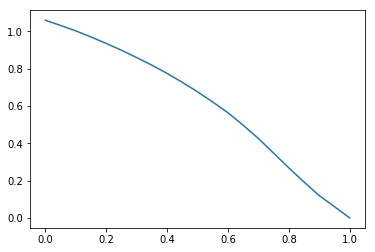

In [14]:
plt.plot(gamma, pv_changes)

In [ ]:
investment_standalone = solve_standalone(gen_per_m2, load_kw, dataids, a_max_firms, pi_s, pi_r, pi_nm)

In [ ]:
print('\n')
print('Investment decisions:')
print(investment_standalone) #Print investment decisions
print('\n')
print('Percentage of investment per firm (with respect to max_cap)')
print(1-(a_max_firms - investment_standalone)/a_max_firms) #Print percentage of investment of available max cap
print('\n Total Investment of PV in standalone case is '+ str(sum(investment_standalone)) + ' in m2 \n')

In [ ]:
soluc_sharing = solve_sharing_collective(gen_per_m2, load_kw, dataids_array, a_max_firms, pi_s, pi_r)
sol_sharing = firms_investment_sharing(soluc_sharing, a_max_firms, firms)

In [ ]:
coll_load = f_collective_load(load_kw)
coll_gen = f_collective_gen(gen_per_m2, sol_sharing)
hours_neg = f_hours_collective_net_load_negative(coll_load, coll_gen)

In [ ]:
(np.sum(sol_sharing) - np.sum(investment_standalone))/np.sum(investment_standalone)

In [ ]:
np.sum(aux, axis=1).shape

In [21]:
df2 = pd.read_csv('data/LMP_2017_data.csv')
pi_g = f_lmp_prices(df2) #Data is in $/MWh
pi_g = pi_g/1000 # convert to $/kWh

In [22]:
a_max_firms = 0.5*a_cap_firms

In [79]:
def solve_wholesale_aggregator_demandcharge2(gen_per_m2, load_kw, a_max_firms, pi_s, pi_g, demand_charge):
    firms = len(a_max_firms)
    a_inv = cvx.Variable(firms)
    T = len(gen_per_m2[:,0])
    
    #obtain timeseries for each month
    load_jan = load_kw[0:24*31, :]
    gen_jan = gen_per_m2[0:24*31, :]
    load_feb =  load_kw[24*31:24*59, :]
    gen_feb = gen_per_m2[24*31:24*59, :]
    load_mar = load_kw[24*59:24*90, :]
    gen_mar = gen_per_m2[24*59:24*90, :]
    load_apr = load_kw[24*90:24*120 , :]
    gen_apr = gen_per_m2[24*90:24*120 , :]
    load_may = load_kw[24*120:24*151 , :]
    gen_may = gen_per_m2[24*120:24*151 , :]
    load_jun = load_kw[24*151:24*181 , :]
    gen_jun = gen_per_m2[24*151:24*181 , :]
    load_jul = load_kw[24*181:24*212 , :]
    gen_jul = gen_per_m2[24*181:24*212 , :]
    load_aug = load_kw[24*212:24*243 , :]
    gen_aug = gen_per_m2[24*212:24*243 , :]
    load_sep = load_kw[24*243:24*273 , :]
    gen_sep = gen_per_m2[24*243:24*273 , :]
    load_oct = load_kw[24*273:24*304 , :]
    gen_oct = gen_per_m2[24*273:24*304 , :]
    load_nov = load_kw[24*304:24*334 , :]
    gen_nov = gen_per_m2[24*304:24*334 , :]
    load_dec = load_kw[24*334: , :]
    gen_dec = gen_per_m2[24*334: , :]
    
    d_charge = demand_charge/12  #average monthly payment 
    load_cost_matrix = (load_kw.T * pi_g).T #define a matrix of size (8754, 1000) that contains the cost of purchasing electricity
    gen_profit_matrix = (gen_per_m2.T * pi_g).T #define a matrix of size (8754, 1000) that contains the cost of selling electricity per m2
    obj = pi_s*cvx.sum(a_inv) + np.sum(load_cost_matrix)/T - cvx.sum(a_inv*np.sum(gen_profit_matrix,axis=0))/T
    obj = obj + d_charge* cvx.norm(np.sum(load_jan,axis=1) - gen_jan*a_inv,'inf') + d_charge* cvx.norm(np.sum(load_feb,axis=1) - gen_feb*a_inv,'inf') 
    obj = obj + d_charge* cvx.norm(np.sum(load_mar,axis=1) - gen_mar*a_inv,'inf') + d_charge* cvx.norm(np.sum(load_apr,axis=1) - gen_apr*a_inv,'inf') 
    obj = obj + d_charge* cvx.norm(np.sum(load_may,axis=1) - gen_may*a_inv,'inf') + d_charge* cvx.norm(np.sum(load_jun,axis=1) - gen_jun*a_inv,'inf') 
    obj = obj + d_charge* cvx.norm(np.sum(load_jul,axis=1) - gen_jul*a_inv,'inf') + d_charge* cvx.norm(np.sum(load_aug,axis=1) - gen_aug*a_inv,'inf') 
    obj = obj + d_charge* cvx.norm(np.sum(load_sep,axis=1) - gen_sep*a_inv,'inf') + d_charge* cvx.norm(np.sum(load_oct,axis=1) - gen_oct*a_inv,'inf') 
    obj = obj + d_charge* cvx.norm(np.sum(load_nov,axis=1) - gen_nov*a_inv,'inf') + d_charge* cvx.norm(np.sum(load_dec,axis=1) - gen_dec*a_inv,'inf') 
    constraints = [a_inv >= 0, a_inv <= a_max_firms]
    prob = cvx.Problem(cvx.Minimize(obj), constraints)
    prob.solve(solver=cvx.GUROBI, verbose=True)
    print("optimal value with GUROBI:", prob.value)
    return a_inv.value

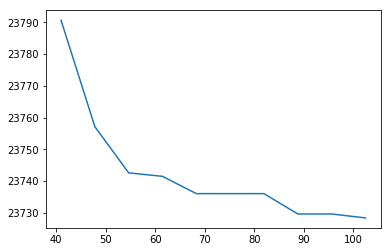

In [80]:
pi_g2 = pi_g
pi_s_array = np.linspace(0.08, 0.2, 10)*pi_s
#pi_s_array = [0.15*pi_s, 0.2*pi_s]
sol_wholesale_list = []
for pi_s2 in pi_s_array:
    soluc_wholesale = solve_wholesale_aggregator_demandcharge2(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2)
    sol_wholesale_list.append(np.sum(soluc_wholesale))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T
plt.plot(levelized_cost_array, sol_wholesale_list)

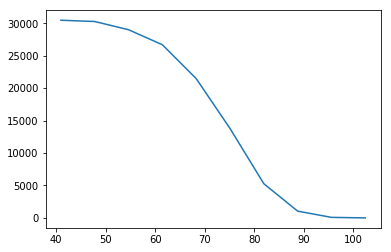

In [81]:
pi_g2 = pi_g
pi_s2 = 0.11*pi_s
pi_s_array = np.linspace(0.08, 0.2, 10)*pi_s
#pi_s_array = [0.15*pi_s, 0.2*pi_s]
sol_wholesale_list = []
for pi_s2 in pi_s_array:
    soluc_wholesale = solve_wholesale_aggregator(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2)
    sol_wholesale_list.append(np.sum(soluc_wholesale))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T
plt.plot(levelized_cost_array, sol_wholesale_list)

In [ ]:
avg_profit_nopv = utility_profit_no_investment(load_kw, pi_r)

In [ ]:
avg_profit_standalone = utility_profit_standalone(gen_per_m2, load_kw, investment_standalone, pi_r, pi_nm)

In [ ]:
avg_profit_sharing = utility_profit_sharing(gen_per_m2, load_kw, sol_sharing, pi_r)

In [39]:
pi_s_array = np.linspace(0.1, 0.2, 11)*pi_s
print(pi_s_array)

[0.0004695  0.00051645 0.0005634  0.00061035 0.0006573  0.00070425
 0.0007512  0.00079815 0.0008451  0.00089205 0.00093901]


In [48]:
np.sum(load_kw, axis=1).size

8754

In [55]:
aux = a_max_firms*gen_per_m2

In [59]:
print(aux[10,1])
print(gen_per_m2[10,1])
print(a_max_firms[1]*gen_per_m2[10,1])

1.1510310999052593
0.03198223676164852
1.1510310999052593


In [ ]:
df3 = df2.groupby(['OPR_HR']).mean()
print(df3)

In [ ]:
df4 = df2.mean()

In [ ]:
print(df4)

In [47]:
8754/12

729.5

In [64]:
31+28+31

90

In [84]:
localtime_data[24*334:]

8016    2017-12-01 00:00:00
8017    2017-12-01 01:00:00
8018    2017-12-01 02:00:00
8019    2017-12-01 03:00:00
8020    2017-12-01 04:00:00
8021    2017-12-01 05:00:00
8022    2017-12-01 06:00:00
8023    2017-12-01 07:00:00
8024    2017-12-01 08:00:00
8025    2017-12-01 09:00:00
8026    2017-12-01 10:00:00
8027    2017-12-01 11:00:00
8028    2017-12-01 12:00:00
8029    2017-12-01 13:00:00
8030    2017-12-01 14:00:00
8031    2017-12-01 15:00:00
8032    2017-12-01 16:00:00
8033    2017-12-01 17:00:00
8034    2017-12-01 18:00:00
8035    2017-12-01 19:00:00
8036    2017-12-01 20:00:00
8037    2017-12-01 21:00:00
8038    2017-12-01 22:00:00
8039    2017-12-01 23:00:00
8040    2017-12-02 00:00:00
8041    2017-12-02 01:00:00
8042    2017-12-02 02:00:00
8043    2017-12-02 03:00:00
8044    2017-12-02 04:00:00
8045    2017-12-02 05:00:00
               ...         
8724    2017-12-30 12:00:00
8725    2017-12-30 13:00:00
8726    2017-12-30 14:00:00
8727    2017-12-30 15:00:00
8728    2017-12-30 1

In [53]:
load_cost_matrix = (load_kw.T * pi_g).T

In [56]:
load_cost_january = load_cost_matrix[0:24*31-1, :]

In [58]:
load_cost_january.shape

(743, 1000)

In [86]:
np.max([1,2,4])

4